<a href="https://colab.research.google.com/github/A-Midhat/nn-by-hand/blob/main/alimidhat_ML_Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> <h2>Ali Midhat Abdelgadir Abdalla</h2>

##Predfined Code

In [ ]:
import numpy as np
import pandas as pd
import random
import math
np.random.seed(42)

import matplotlib.pyplot as plt
FONTSIZE = 16
params = {
         'figure.figsize' : (6,6),
         'axes.labelsize' : FONTSIZE,
         'axes.titlesize' : FONTSIZE+2,
         'legend.fontsize': FONTSIZE,
         'xtick.labelsize': FONTSIZE,
         'ytick.labelsize': FONTSIZE,
         'xtick.color'    : 'black',
         'ytick.color'    : 'black',
         'axes.facecolor' : 'white',
         'axes.edgecolor' : 'black',
         'axes.titlepad'  :  20,
         'axes.labelpad'  :  10}
plt.rcParams.update(params)

XNAME = 'x1'; XLABEL = r'$x_1$'
YNAME = 'x2'; YLABEL = r'$x_2$'
RANGE = (-6, 6); STEP = 0.1

def predict(output_node, boundary_value):
  output_node.reshape(-1, 1, 1) # a list (m, 1, 1)
  predictions = np.array(output_node > boundary_value, dtype=int)
  return predictions

def plot_cost_vs_iter(train_costs, test_costs, title="Cost evolution"):

  fig, ax = plt.subplots(figsize=(8, 6))
  iters = np.arange(1,len(train_costs)+1)
  ax.plot(iters, train_costs, color='red', lw=1, label='Training set')
  ax.plot(iters, test_costs, color='blue', lw=1, label='Testing set')
  ax.set_xlabel("Number of iterations"); ax.set_xlim(1, iters[-1])
  ax.set_ylabel("Cost")
  ax.legend(loc="upper right", frameon=False)
  plt.grid(True, alpha=0.5) # added this line
  ax.set_title(title)
  plt.show()


def get_decision_surface(weights, biases, boundary=0.5, range=RANGE, step=STEP):

  # Create a grid of points spanning the parameter space:
  x1v, x2v = np.meshgrid(np.arange(range[0], range[1]+step, step),
                         np.arange(range[0], range[1]+step, step))

  # Stack it so that it is shaped like X_train: (m,2)
  X_grid = np.c_[x1v.ravel(), x2v.ravel()].reshape(-1,2)

  # Feedforward on all grid points and get binary predictions:
  output = feedforward(X_grid, weights, biases)[-1] # getting only output node
  Ypred_grid = predict(output, boundary)

  return (x1v, x2v, Ypred_grid.reshape(x1v.shape))


def plot_scatter(sig, bkg, ds=None, xname=XNAME, xlabel=XLABEL, yname=YNAME, ylabel=YLABEL, range=RANGE, step=STEP, title="Scatter plot"):

  fig, ax = plt.subplots()

  # Decision surface
  if ds:
    (xx, yy, Z) = ds # unpack contour data
    cs = plt.contourf(xx, yy, Z, levels=[0,0.5,1], colors=['orange','dodgerblue'], alpha=0.3)

  # Scatter signal and background:
  ax.scatter(sig[xname], sig[yname], marker='o', s=10, c='dodgerblue', alpha=1, label='Positive class')
  ax.scatter(bkg[xname], bkg[yname], marker='o', s=10, c='orange',     alpha=1, label='Negative class')

  # Axes, legend and plot:
  ax.set_xlim(range); ax.set_xlabel(xlabel)
  ax.set_ylim(range); ax.set_ylabel(ylabel)

  ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", frameon=False)
  ax.set_title(title)
  plt.show()

## (1)

### (1.1)

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/Copy of ml_a3_data_train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Copy of ml_a3_data_test.csv")

In [ ]:
train_df.count()

,0
x1,320
x2,320
class,320


In [ ]:
test_df.count()

,0
x1,80
x2,80
class,80


---
Train dataset:

* There are 320 input samples.

Test dataset:
* Contain 80 samples.
---

* Label column is named class.
* Possible class values are either 0 or 1.
---

###(1.2) delete the plot

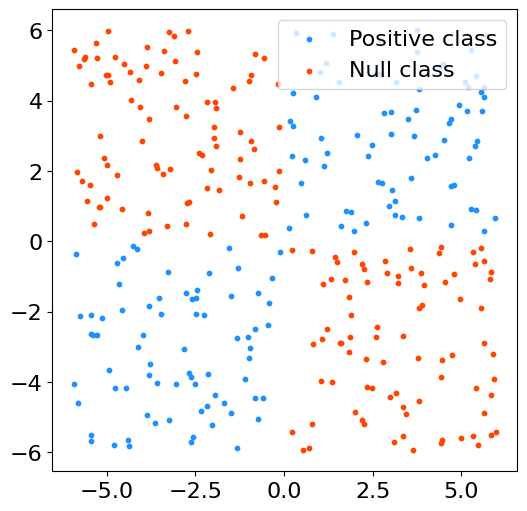

In [ ]:
# split into sig and bkg
sig = train_df[train_df['class'] == 1]
bkg = train_df[train_df['class'] == 0]

plt.scatter(sig['x1'], sig['x2'], marker='o', s=10, c='dodgerblue', alpha=1, label='Positive class')
plt.scatter(bkg['x1'], bkg['x2'], marker='o', s=10, c='orangered', alpha=1, label='Null class')
plt.legend()
plt.show()

###(1.3)

In [ ]:
inputs = ['x1', 'x2']
X_train = train_df[inputs].to_numpy()
y_train = train_df["class"].to_numpy()

X_test = test_df[inputs].to_numpy()
y_test = test_df["class"].to_numpy()

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((320, 2), (320,), (80, 2), (80,))

## (2)

### (2.1)

In [ ]:
# weighted sum
def z(inputs, weights, bias):
  return np.dot(inputs, weights.T) + bias


### (2.2)

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z) * (1 - sigmoid(z))

def tanh(z):
    return np.tanh(z)

def tanh_prime(z):
    return 1 - np.tanh(z)**2

### (2.3)

In [ ]:
def cross_entropy_cost(y_preds, y_vals):
    epsilon = 1e-10  # Small value to prevent log(0)
    y_preds = np.clip(y_preds, epsilon, 1 - epsilon)  # Avoids log(0)
    return -np.mean(y_vals * np.log(y_preds) + (1 - y_vals) * np.log(1 - y_preds))

###(2.4)

---



**Derivative of the Loss Function**  

$$L(\hat y^{(i)}, y^{(i)}) = - \left[ y^{(i)} \log(\hat y^{(i)}) + (1 - y^{(i)})\log(1 - \hat y^{(i)}) \right]$$  


we differentiate w.r.t $ \hat{y}^{(i)}$:

$$
\frac{d}{d\hat{y}^{(i)}} L(\hat{y}^{(i)}, y^{(i)}) = - \left[ \frac{y^{(i)}}{\hat{y}^{(i)}} - \frac{(1 - y^{(i)})}{(1 - \hat{y}^{(i)})} \right]
$$

$$
\frac{d}{d\hat{y}^{(i)}} L(\hat{y}^{(i)}, y^{(i)}) = \frac{ \hat y^{(i)}(1 - y^{(i)}) - y^{(i)}(1 - \hat y^{(i)}) }{\hat y^{(i)}(1 - \hat y^{(i)})}
$$

$$
\frac{d}{d\hat{y}^{(i)}} L(\hat{y}^{(i)}, y^{(i)}) = \frac{\hat y^{(i)} - y^{(i)}}{\hat y^{(i)}(1 - \hat y^{(i)})}
$$

---



In [ ]:
def L_prime(y_preds, y_obs):
  return (y_preds - y_obs)/(y_preds * (1 - y_preds))

##(3)

###(3.1)

In [ ]:
#Two input nodes, Two hidden layers (3,2), and one output node
# Hidded uses tanh, output uses sigmoid
def feedforward(input_X, weights, biases):

    W1, W2, W3 = weights
    b1, b2, b3 = biases

    # m  = len(input_X)
    a0 = input_X


    # First layer
    z1 = z(a0, W1, b1)
    a1 = tanh(z1)

    # Second layer
    z2 = z(a1, W2, b2)
    a2 = tanh(z2)

    # Third layer.T
    z3 = z(a2, W3, b3)
    a3 = sigmoid(z3)

    nodes = [a0, z1, a1, z2, a2, z3, a3]

    return nodes


###(3.2)



**1) What is the `output_node` in our 2-hidden-layer neural network?**

We have two hidden layers (each using $\tanh$ and one output layer (using $\sigma(\cdot)$), the sigmoid function). In the **feedforward** function:

$$
\begin{aligned}
z_3 &= W_3\, a_2 + b_3,\\
a_3 &= \sigma(z_3),
\end{aligned}
$$

the final activation \(a_3\) is the `output_node`. Concretely, it is:
```python
a3 = sigmoid(z3)
```
---

**2)What type of values does the function predict return?**

returns an array of integer values (either 0 or 1). Specifically, each element in `output_node` is thresholded by boundary_value (here we use 0.5). If `output_node[i]` is greater than boundary_value, the prediction is 1; otherwise, 0.

---

**3)After successfully executing the feedforward function, how would you call the function predict?**

```
#get all layers' outputs:
all_nodes = feedforward(X_data, weights, biases)

#get final activation (the output node):
output_node = all_nodes[-1]

#get prediction with a threshold of i.e 0.5.
predictions = predict(output_node, 0.5)

```



## (4)

In [ ]:
# seed for reproducibility
np.random.seed(69)
# Hyperparameters
alpha = 0.03
N = 5_000 # epochs

m = X_train.shape[0]  # number of of data samples
n = X_train.shape[1]  # number of input features

q = 3  # first hidden layer nodes
r = 2  # second hidden layer nodes

# Initialize weights using LeCun's init
W1 = np.random.randn(q, n) * np.sqrt(1 / n)
W2 = np.random.randn(r, q) * np.sqrt(1 / q)
W3 = np.random.randn(1, r) * np.sqrt(1 / r)

# Initialize biases with zeros
b1 = np.zeros((q,))
b2 = np.zeros((r,))
b3 = np.zeros((1,))

# Reshape y to (m, 1)
y_train = y_train.reshape(-1, 1)
y_test  = y_test.reshape(-1, 1)

# Storing cost values for train and test datasets
costs_train = []
costs_test  = []


debug = False
print("Starting the training\n")

for t in range(1, N + 1):
    # Forward pass on test data
    nodes_test = feedforward(X_test, [W1, W2, W3], [b1, b2, b3])
    ypreds_test = nodes_test[-1]  # shape (m_test,1)

    # Forward pass on train data
    a0, z1, a1, z2, a2, z3, a3 = feedforward(X_train, [W1, W2, W3], [b1, b2, b3])
    ypreds_train = a3

    # Compute cost
    J_train = cross_entropy_cost(ypreds_train, y_train)
    J_test  = cross_entropy_cost(ypreds_test,  y_test)
    costs_train.append(J_train)
    costs_test.append(J_test)

    if (t <= 100 and t % 10 == 0) or (t > 100 and t % 100 == 0):
        diff = J_test - J_train
        print(f"Iteration {t}\t Train cost = {J_train:.4f}"
              f"  Test cost = {J_test:.4f}   Diff = {diff:.5f}")


    # Backpropagation
    delta_3 = L_prime(ypreds_train, y_train) * sigmoid_prime(z3)
    delta_2 = (delta_3.dot(W3)) * tanh_prime(z2)
    delta_1 = (delta_2.dot(W2)) * tanh_prime(z1)

    # Gradients for W3, W2, W1
    dCostdW3 = (delta_3.T.dot(a2)) / m
    dCostdW2 = (delta_2.T.dot(a1)) / m
    dCostdW1 = (delta_1.T.dot(a0)) / m

    # Bias gradients: average across samples
    dCostdb3 = np.mean(delta_3, axis=0) # we could use np.mean instead of dividing by m
    dCostdb2 = np.mean(delta_2, axis=0)
    dCostdb1 = np.mean(delta_1, axis=0)
    if debug and t<3:
        print(f"a0: {a0.shape} a1: {a1.shape} a2: {a2.shape} a3: {a3.shape} ")
        print(f"W3: {W3.shape} z1: {z1.shape} z2: {z2.shape} z3: {z3.shape} ")
        print(f"dCostdW3: {dCostdW3.shape} dCostdW2: {dCostdW2.shape} dCostdW1: {dCostdW1.shape}")

    # Gradient descent step
    # wights
    W3 -= alpha * dCostdW3
    W2 -= alpha * dCostdW2
    W1 -= alpha * dCostdW1
    # biases
    b3 -= alpha * dCostdb3
    b2 -= alpha * dCostdb2
    b1 -= alpha * dCostdb1

print(f"\nEnd of gradient descent after {t} iterations")


Starting the training

Iteration 10	 Train cost = 0.6993  Test cost = 0.6896   Diff = -0.00972
Iteration 20	 Train cost = 0.6981  Test cost = 0.6902   Diff = -0.00799
Iteration 30	 Train cost = 0.6971  Test cost = 0.6907   Diff = -0.00640
Iteration 40	 Train cost = 0.6960  Test cost = 0.6911   Diff = -0.00492
Iteration 50	 Train cost = 0.6950  Test cost = 0.6915   Diff = -0.00354
Iteration 60	 Train cost = 0.6940  Test cost = 0.6918   Diff = -0.00226
Iteration 70	 Train cost = 0.6931  Test cost = 0.6920   Diff = -0.00105
Iteration 80	 Train cost = 0.6921  Test cost = 0.6922   Diff = 0.00010
Iteration 90	 Train cost = 0.6912  Test cost = 0.6923   Diff = 0.00118
Iteration 100	 Train cost = 0.6902  Test cost = 0.6924   Diff = 0.00222
Iteration 200	 Train cost = 0.6811  Test cost = 0.6920   Diff = 0.01092
Iteration 300	 Train cost = 0.6731  Test cost = 0.6905   Diff = 0.01739
Iteration 400	 Train cost = 0.6643  Test cost = 0.6854   Diff = 0.02114
Iteration 500	 Train cost = 0.6517  Test co

## (5)

###(5.1)

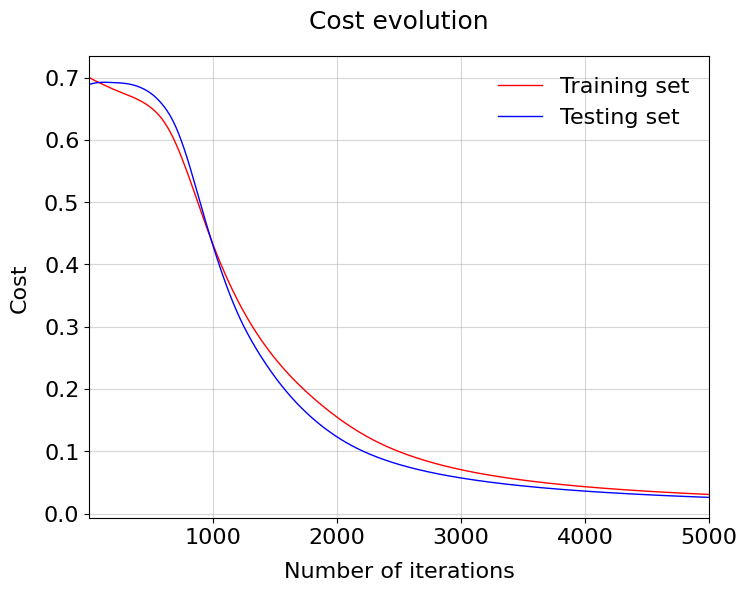

In [ ]:
plot_cost_vs_iter(costs_train, costs_test)

###(5.2)

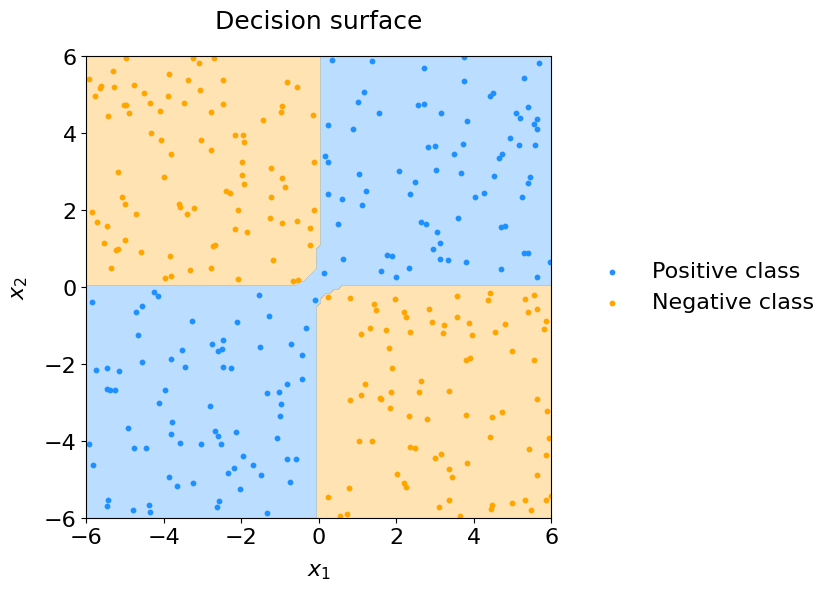

In [ ]:
ds = get_decision_surface([W1, W2, W3], [b1, b2, b3], boundary=0.5)
plot_scatter(sig, bkg, ds=ds, title="Decision surface")

##Bonus

>Generalized Neural Net class, that accepts multiple layers.

In [ ]:
class NeuralNetwork:
    def __init__(self, layer_dims, activations, learning_rate):
        self.layer_dims = layer_dims
        self.activations = activations
        self.learning_rate = learning_rate
        self.parameters = self.initialize_weights()

    def initialize_weights(self):
        np.random.seed(69)
        parameters = {}
        L = len(self.layer_dims)

        for l in range(1, L):
            parameters[f"W{l}"] = np.random.randn(self.layer_dims[l], self.layer_dims[l-1]) * np.sqrt(1 / self.layer_dims[l-1])
            parameters[f"b{l}"] = np.zeros((self.layer_dims[l], 1))
        return parameters

    def activation_function(self, Z, activation):

        if activation == "relu":
            return np.maximum(0, Z)
        elif activation == "sigmoid":
            return self.sigmoid(Z)
        elif activation == "tanh":
            return self.tanh(Z)
        else:
            raise ValueError("Unsupported activation function")

    def activation_derivative(self, Z, activation):

        if activation == "relu":
            return (Z > 0).astype(float)
        elif activation == "sigmoid":
            A = self.activation_function(Z, "sigmoid")
            return self.sigmoid_prime(A)
        elif activation == "tanh":
            A = self.activation_function(Z, "tanh")
            return self.tanh_prime(A)
        else:
            raise ValueError("Unsupported activation function")

    def feedforward(self, X):

        L = len(self.activations)
        cache = {"A0": X}

        A = X
        for l in range(1, L + 1):
            Z = np.dot(self.parameters[f"W{l}"], A) + self.parameters[f"b{l}"]
            A = self.activation_function(Z, self.activations[l-1])
            cache[f"Z{l}"] = Z
            cache[f"A{l}"] = A

        return A, cache

    def backpropagation(self, Y, cache):
        L = len(self.activations)
        grads = {}
        m = Y.shape[1]
        A_L = cache[f"A{L}"]

        epsilon = 1e-10
        A_L = np.clip(A_L, epsilon, 1 - epsilon)

        dA = self.L_prime(A_L,Y)
        dZ = dA * self.activation_derivative(cache[f"Z{L}"], self.activations[-1])
        dZ = np.clip(dZ, -1, 1)

        grads[f"dW{L}"] = np.clip((1 / m) * np.dot(dZ, cache[f"A{L-1}"].T), -1, 1)
        grads[f"db{L}"] = np.clip((1 / m) * np.sum(dZ, axis=1, keepdims=True), -1, 1)


        for l in range(L-1, 0, -1):
            dA = np.dot(self.parameters[f"W{l+1}"].T, dZ)
            dZ = dA * self.activation_derivative(cache[f"Z{l}"], self.activations[l-1])
            dZ = np.clip(dZ, -1, 1)  # Clip gradients

            grads[f"dW{l}"] = np.clip((1 / m) * np.dot(dZ, cache[f"A{l-1}"].T), -1, 1)
            grads[f"db{l}"] = np.clip((1 / m) * np.sum(dZ, axis=1, keepdims=True), -1, 1)

        return grads


    def update_parameters(self, grads):

        L = len(self.activations)
        for l in range(1, L + 1):
            self.parameters[f"W{l}"] -= self.learning_rate * grads[f"dW{l}"]
            self.parameters[f"b{l}"] -= self.learning_rate * grads[f"db{l}"]

    def L_prime(self, y_preds, y_obs):
        return (y_preds - y_obs)/(y_preds * (1 - y_preds))

    def predict(self, X):

        Y_pred, _ = self.feedforward(X)
        return (Y_pred >= 0.5).astype(int)

    def tanh(self,z):
        return np.tanh(z)

    def sigmoid(self,z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_prime(self,z):
        return sigmoid(z) * (1 - sigmoid(z))

    def tanh_prime(self,z):
        return 1 - np.tanh(z)**2

    def cross_entropy_cost(self,y_preds, y_vals):
        epsilon = 1e-10
        y_preds = np.clip(y_preds, epsilon, 1 - epsilon) # avoid log zero
        return -np.mean(y_vals * np.log(y_preds) + (1 - y_vals) * np.log(1 - y_preds))

    def get_decision_surface(self, nn_model, boundary=0.5, range_val=(-6, 6), step=0.1):

        x1_vals, x2_vals = np.meshgrid(np.arange(range_val[0], range_val[1], step),
                                      np.arange(range_val[0], range_val[1], step))
        X_grid = np.c_[x1_vals.ravel(), x2_vals.ravel()].T
        Y_pred_grid = nn_model.predict(X_grid)
        return x1_vals, x2_vals, Y_pred_grid.reshape(x1_vals.shape)
    def train(self, X_train, Y_train, epochs=1000):
        costs = []
        for epoch in range(1, epochs+1):

            Y_pred, cache = self.feedforward(X_train)

            cost = self.cross_entropy_cost(Y_pred,Y_train)
            costs.append(cost)

            grads = self.backpropagation(Y_train, cache)

            self.update_parameters(grads)

            if (epoch <= 100 and epoch % 10 == 0) or (epoch > 100 and epoch % 100 == 0):
                  print(f"Iteration {epoch}\t Train cost = {cost:.4f}")

        return costs



layer_dims = [2,16, 8, 1]
activations = ["tanh", "tanh", "sigmoid"]

nn = NeuralNetwork(layer_dims, activations, learning_rate=0.01)
costs = nn.train(X_train.T, y_train.T, epochs=5000)

y_pred_train = nn.predict(X_train.T)
y_pred_test = nn.predict(X_test.T)

Iteration 10	 Train cost = 0.7042
Iteration 20	 Train cost = 0.7017
Iteration 30	 Train cost = 0.6997
Iteration 40	 Train cost = 0.6981
Iteration 50	 Train cost = 0.6968
Iteration 60	 Train cost = 0.6957
Iteration 70	 Train cost = 0.6948
Iteration 80	 Train cost = 0.6941
Iteration 90	 Train cost = 0.6934
Iteration 100	 Train cost = 0.6928
Iteration 200	 Train cost = 0.6881
Iteration 300	 Train cost = 0.6837
Iteration 400	 Train cost = 0.6789
Iteration 500	 Train cost = 0.6734
Iteration 600	 Train cost = 0.6670
Iteration 700	 Train cost = 0.6594
Iteration 800	 Train cost = 0.6505
Iteration 900	 Train cost = 0.6402
Iteration 1000	 Train cost = 0.6284
Iteration 1100	 Train cost = 0.6153
Iteration 1200	 Train cost = 0.6009
Iteration 1300	 Train cost = 0.5852
Iteration 1400	 Train cost = 0.5684
Iteration 1500	 Train cost = 0.5506
Iteration 1600	 Train cost = 0.5318
Iteration 1700	 Train cost = 0.5121
Iteration 1800	 Train cost = 0.4915
Iteration 1900	 Train cost = 0.4703
Iteration 2000	 Tra

In [ ]:
def get_decision_surface(nn_model, boundary=0.5, range_val=(-6, 6), step=0.1):
    x1_vals, x2_vals = np.meshgrid(np.arange(range_val[0], range_val[1], step),
                                   np.arange(range_val[0], range_val[1], step))
    X_grid = np.c_[x1_vals.ravel(), x2_vals.ravel()].T
    Y_pred_grid = nn_model.predict(X_grid)
    return x1_vals, x2_vals, Y_pred_grid.reshape(x1_vals.shape)

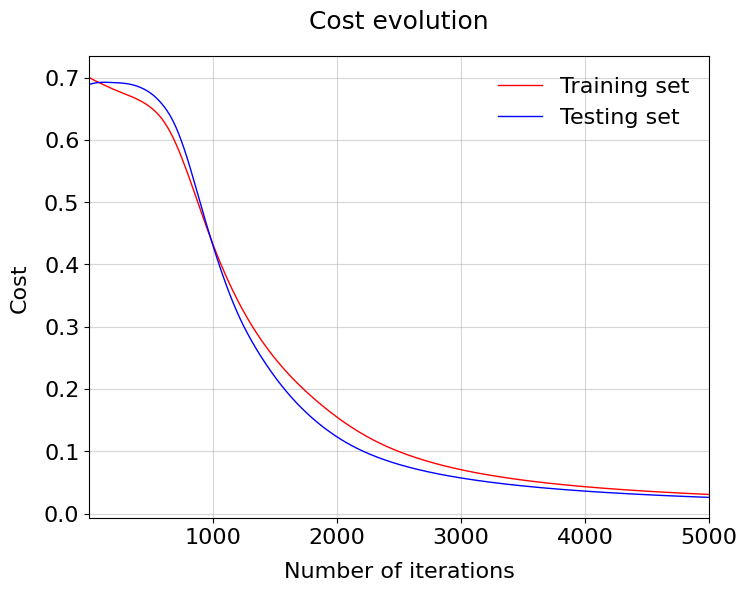

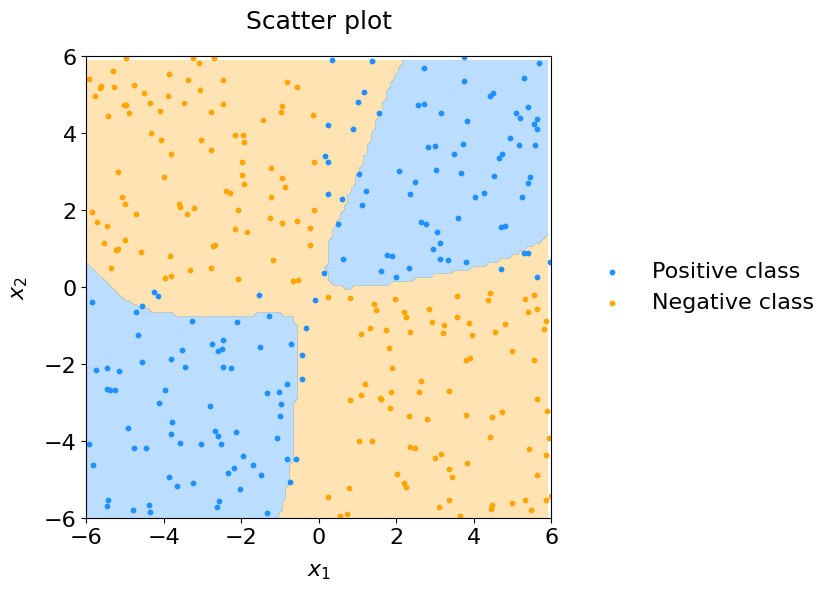

In [ ]:

X_train_df = pd.DataFrame(X_train, columns=["x1", "x2"])
y_train_df = pd.Series(y_train.flatten(), name="class")

sig = X_train_df[y_train_df == 1]
bkg = X_train_df[y_train_df == 0]

plot_cost_vs_iter(costs_train, costs_test)


decision_surface = get_decision_surface(nn, 0.5)


plot_scatter(sig, bkg, decision_surface)
